In [1]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


## Read the data

In [3]:
adults_data_orig = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",header=None)

In [4]:
adults_data = adults_data_orig.copy()

In [5]:
adults_data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "label"]

In [6]:
adults_data.sex = (adults_data.sex==' Male').astype(int)
adults_data.label = (adults_data.label==' >50K').astype(int)

In [7]:
adults_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,0,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,1,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,0,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,1,0,0,20,United-States,0


## Discover the data

In [8]:
adults_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  int64 
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  label           32561 non-null  int64 
dtypes: int64(8), object(7)
memory usage: 3.7+ MB


In [9]:
adults_data.describe()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,label
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,0.669205,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,0.470506,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,1.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,1.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,1.000000,99999.000000,4356.000000,99.000000,1.000000


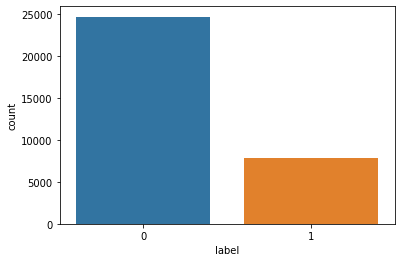

In [10]:
sns.countplot(x = 'label', data=adults_data)

In [11]:
adults_data.loc[adults_data['label'] == 1].shape[0] / adults_data.shape[0]

0.2408095574460244

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a3795f690>,
      dtype=object)

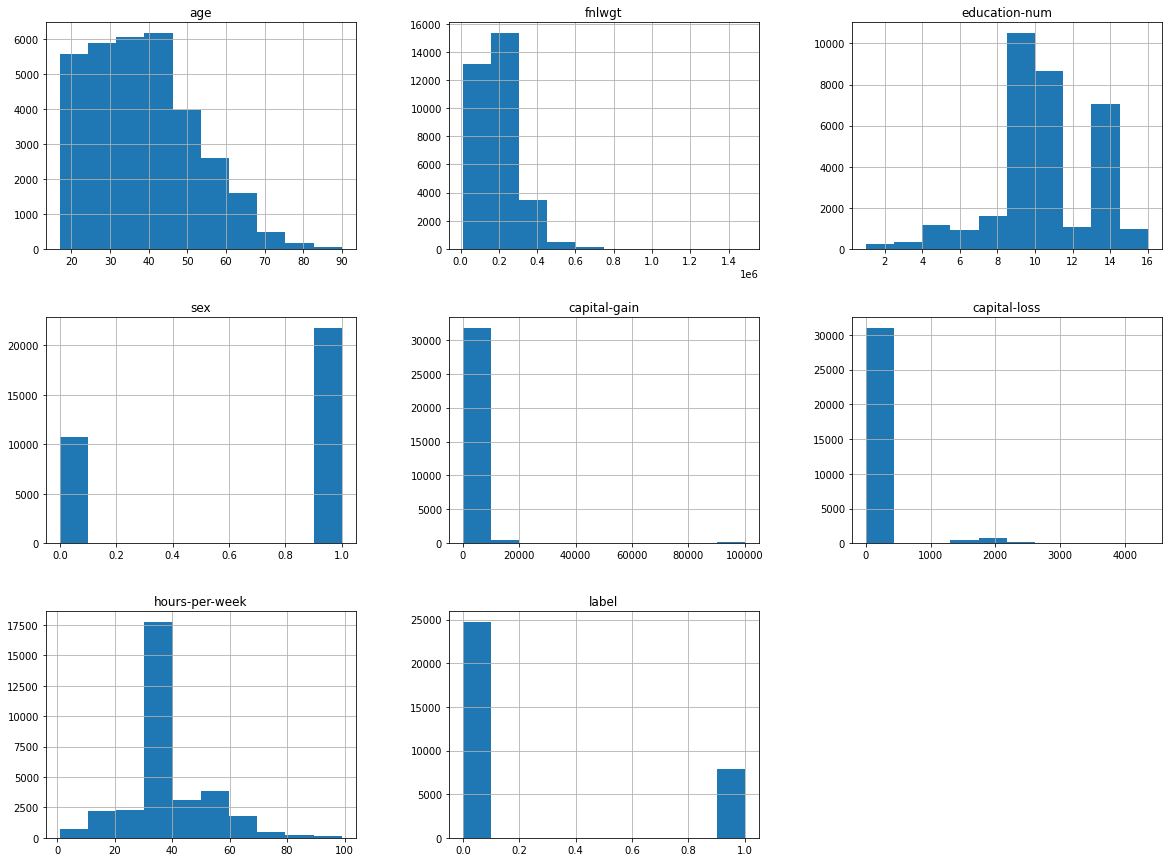

In [12]:
adults_data.hist(figsize=(20,15))

### Looking for correlations

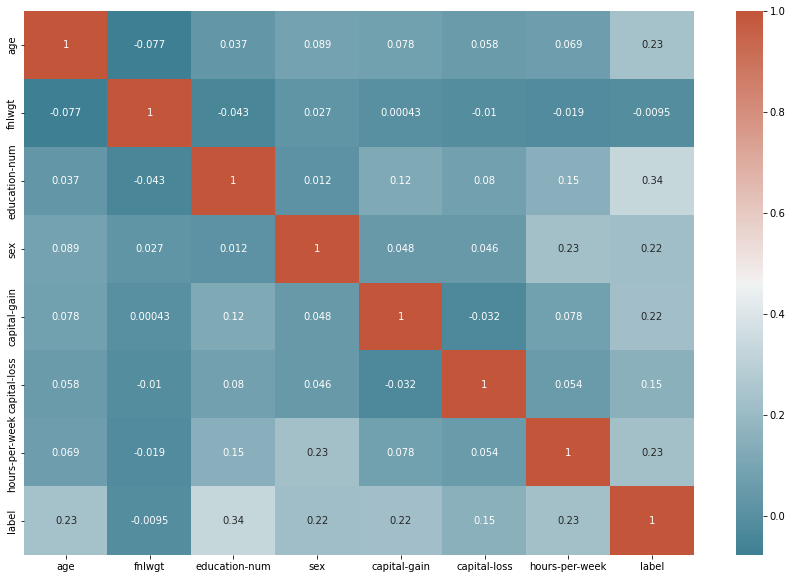

In [13]:
corr = adults_data.corr()
matplotlib.pyplot.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

Try to bucketize the age attribute to increase correlation

In [14]:
discr = KBinsDiscretizer(n_bins=7, encode='ordinal')
discr.fit(adults_data['age'].to_numpy().reshape(-1,1))
discr_age = discr.transform(adults_data['age'].to_numpy().reshape(-1,1))

In [15]:
adults_data['age'] = discr_age

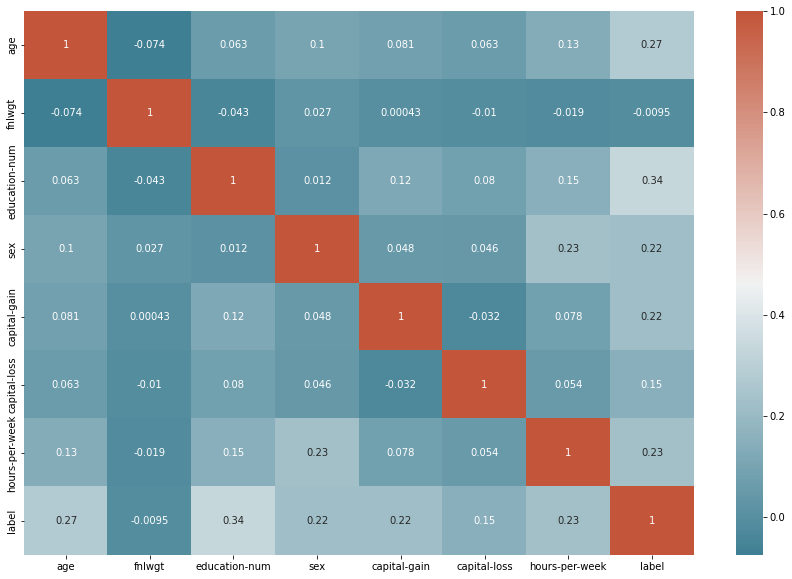

In [16]:
corr = adults_data.corr()
matplotlib.pyplot.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [17]:
adults_data.drop(columns=['fnlwgt'], inplace=True)

- workclass -> onehot, embedding
- education -> onehot, embedding
- marital-status -> onehot, embedding
- occupation -> onehot, embedding 
- relationship -> onehot, embedding
- native-country -> onehot, embedding
- race -> onehot, embedding

In [18]:
categorical_columns = ["workclass", 'occupation', 'marital-status', 'education', 'relationship', 'race', 'native-country']
categorical_values = pd.get_dummies(adults_data[categorical_columns], drop_first=True)
categorical_values.head()

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,...,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
adults_data.drop(columns=categorical_columns,inplace=True)

In [20]:
y = adults_data.values[:,-1]
y

array([0., 0., 0., ..., 0., 0., 1.])

Scale the data

In [21]:
scaler = StandardScaler()
scaler.fit(adults_data)
adults_data = scaler.transform(adults_data)
adults_data

array([[-0.04405539,  1.13473876,  0.70307135, ..., -0.21665953,
        -0.03542945, -0.56319851],
       [ 0.9693587 ,  1.13473876,  0.70307135, ..., -0.21665953,
        -2.22215312, -0.56319851],
       [-0.04405539, -0.42005962,  0.70307135, ..., -0.21665953,
        -0.03542945, -0.56319851],
       ...,
       [ 1.47606575, -0.42005962, -1.42233076, ..., -0.21665953,
        -0.03542945, -0.56319851],
       [-1.56417653, -0.42005962,  0.70307135, ..., -0.21665953,
        -1.65522476, -0.56319851],
       [ 0.9693587 , -0.42005962, -1.42233076, ..., -0.21665953,
        -0.03542945,  1.77557289]])

In [22]:
train_indices = np.random.rand(len(adults_data))>0.3

In [23]:
numerical_data = torch.from_numpy(adults_data[train_indices,:-1]).float()
categorical_data = torch.from_numpy(categorical_values.values[train_indices]).float()
targets = torch.from_numpy(y[train_indices]).float()

test_numerical_data = torch.from_numpy(adults_data[~train_indices,:-1]).float()
test_categorical_data = torch.from_numpy(categorical_values.values[~train_indices]).float()
test_targets = torch.from_numpy(y[~train_indices]).float()

In [24]:
train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
test_dataset = data.TensorDataset(test_numerical_data,test_categorical_data,test_targets)

In [25]:
class Adults_classifier(nn.Module):
    def __init__(self):
        super(Adults_classifier, self).__init__()
        self.emb_layer1 = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb1 = nn.Tanh()
        self.emb_drop1 = nn.Dropout(0.3)
        self.emb_layer2 = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb2 = nn.Tanh()
        self.emb_drop2 = nn.Dropout(0.3)
        self.layer1 = nn.Linear(adults_data.shape[1] -1 + categorical_data.shape[1], 20)
        self.act_1 =  nn.LeakyReLU()
        self.drop1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(20)
        self.layer2 = nn.Linear(20, 10)
        self.act_2 =  nn.LeakyReLU()
        self.drop2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm1d(10)
        self.layer3 = nn.Linear(10, 1)
    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_drop1(self.act_emb1(self.emb_layer1(cat_x)))
        cat_x_embedded = self.emb_drop2(self.act_emb2(self.emb_layer2(cat_x_embedded)))
        x = torch.cat([x,cat_x_embedded],dim=1)
        x = self.bn1(self.drop1(self.act_1(self.layer1(x))))
        x = self.bn2(self.drop2(self.act_2(self.layer2(x))))
        output = self.layer3(x)
        return output

In [26]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output>0
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [27]:
model = Adults_classifier().to(device)
model

Adults_classifier(
  (emb_layer1): Linear(in_features=93, out_features=93, bias=True)
  (act_emb1): Tanh()
  (emb_drop1): Dropout(p=0.3, inplace=False)
  (emb_layer2): Linear(in_features=93, out_features=93, bias=True)
  (act_emb2): Tanh()
  (emb_drop2): Dropout(p=0.3, inplace=False)
  (layer1): Linear(in_features=99, out_features=20, bias=True)
  (act_1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=20, out_features=10, bias=True)
  (act_2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout(p=0.3, inplace=False)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
iters = []
losses = []
train_acc = []
val_acc = []
for n in range(15):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 0.454 test_acc: 0.846
Epoch 1 loss 0.359 test_acc: 0.848
Epoch 2 loss 0.349 test_acc: 0.85
Epoch 3 loss 0.344 test_acc: 0.853
Epoch 4 loss 0.341 test_acc: 0.856
Epoch 5 loss 0.341 test_acc: 0.852
Epoch 6 loss 0.339 test_acc: 0.854
Epoch 7 loss 0.337 test_acc: 0.848
Epoch 8 loss 0.336 test_acc: 0.851
Epoch 9 loss 0.335 test_acc: 0.855
Epoch 10 loss 0.337 test_acc: 0.851
Epoch 11 loss 0.336 test_acc: 0.853
Epoch 12 loss 0.335 test_acc: 0.845
Epoch 13 loss 0.334 test_acc: 0.852
Epoch 14 loss 0.335 test_acc: 0.853
Final Training Accuracy: 0.8541839632947346
Final Validation Accuracy: 0.8530384456386937


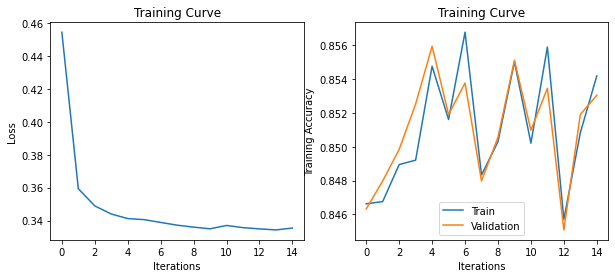

In [29]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

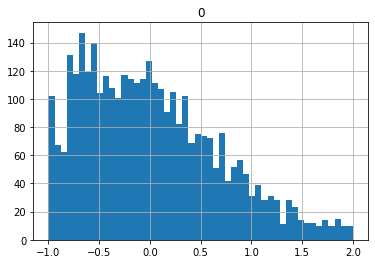

In [30]:
preds = model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-1,2));

In [31]:
(preds>0).sum()

tensor(1693, device='cuda:0')

In [32]:
model = Adults_classifier().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss(pos_weight=(len(targets)-sum(targets))/sum(targets))
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(15):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 0.735 test_acc: 0.758
Epoch 1 loss 0.642 test_acc: 0.781
Epoch 2 loss 0.625 test_acc: 0.795
Epoch 3 loss 0.618 test_acc: 0.777
Epoch 4 loss 0.617 test_acc: 0.774
Epoch 5 loss 0.61 test_acc: 0.772
Epoch 6 loss 0.608 test_acc: 0.784
Epoch 7 loss 0.606 test_acc: 0.8
Epoch 8 loss 0.609 test_acc: 0.8
Epoch 9 loss 0.606 test_acc: 0.792
Epoch 10 loss 0.609 test_acc: 0.774
Epoch 11 loss 0.606 test_acc: 0.787
Epoch 12 loss 0.598 test_acc: 0.795
Epoch 13 loss 0.593 test_acc: 0.788
Epoch 14 loss 0.603 test_acc: 0.8
Final Training Accuracy: 0.8066419051780642
Final Validation Accuracy: 0.7995039272426623


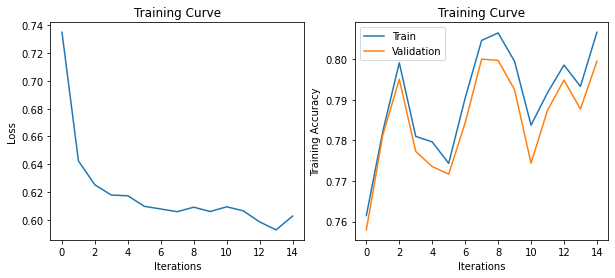

In [33]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

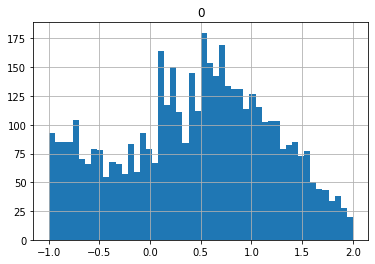

In [34]:
preds = model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-1,2));

In [35]:
(preds>0).sum()

tensor(3599, device='cuda:0')